In [4]:
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import regionprops
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor

/home/tomas/.pyenv/versions/building_extraction_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def visualize_instance_segmentation_map(results, image, model, alpha=0.5):
    """
    Visualizes instance segmentation results (num_instances, H, W) 
    with color overlay and class labels.
    """
    segmentation = results['segmentation'].numpy()
    segments_info = results['segments_info']
    height, width = segmentation.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Assign random color to each instance
    instance_colors = {
    segment['id']: np.random.randint(50, 200, size=3)
    for segment in segments_info
    }

    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    for segment in segments_info:
        label_name = model.config.id2label[segment['label_id']]
        mask = segmentation == segment['id']
        color_mask[mask] = instance_colors[segment['id']]
        score = segment["score"]
        props = regionprops(mask.astype(np.uint8))
        if not props:
            continue
        y, x = props[0].centroid
        text = f"ID: {segment['id']}\n{score:.4f}" if score is not None else ""
        ax.text(
            x, y, text,
            color='white', fontsize=8, weight='bold',
            ha='center', va='center',
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2')
        )

    # Overlay mask on image with alpha blending
    image_np = np.array(image).astype(np.uint8)
    overlay = (1 - alpha) * image_np + alpha * color_mask
    overlay = overlay.astype(np.uint8)

    plt.imshow(overlay)

    plt.axis('off')
    plt.title(f"Instance Segmentation Map - {len(segments_info)} Predicted Buildings")
    plt.show()

def visualize_instance_comparison(pr_instance_map, gt_instance_map, iou_threshold=0.5):
    """
    Visualize predicted vs ground-truth instances.
    - Red: predicted instance (FP)
    - Green: ground-truth instance (FN)
    - Yellow: matched instance (TP)
    """
    h, w = gt_instance_map.shape
    overlay = np.zeros((h, w, 3), dtype=np.uint8)

    # Get unique instance IDs (skip 0 = background)
    pr_ids = [i for i in np.unique(pr_instance_map) if i != 0]
    gt_ids = [i for i in np.unique(gt_instance_map) if i != 0]

    matched_gt = set()

    # Function to compute IoU
    def iou(mask1, mask2):
        inter = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()
        return inter / union if union > 0 else 0.0

    # Loop over predictions
    TP_count, FP_count, FN_count = 0, 0, 0
    for pid in pr_ids:
        pred_mask = pr_instance_map == pid
        color = (255, 0, 0)  # Red by default (FP)
        matched = False
        for gid in gt_ids:
            if gid in matched_gt:
                continue
            gt_mask = gt_instance_map == gid
            iou_val = iou(pred_mask, gt_mask)
            if iou_val >= iou_threshold:
                color = (0, 255, 0)  # Green (TP)
                matched_gt.add(gid)
                matched = True
                break
        
        if matched:
            TP_count += 1
        else:
            FP_count += 1

        # Draw predicted contour
        contours, _ = cv2.findContours(pred_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 1)

    # Draw unmatched ground truth in Yellow (FN)
    for gid in gt_ids:
        if gid not in matched_gt:
            FN_count += 1
            gt_mask = gt_instance_map == gid
            contours, _ = cv2.findContours(gt_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay, contours, -1, (255, 255, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Green=TP ({TP_count})| Red=FP ({FP_count})| Yellow=FN ({FN_count}) ")
    plt.axis("off")
    plt.show()

In [7]:
# ----------------------------------------------------------------------------------------
# Load Dataset from HUB
# ----------------------------------------------------------------------------------------
from datasets import load_dataset

label2id = {"building": 0}  # Start at 0 in Mask2Former
id2label = {0: "building"}  # Start at 0 in Mask2Former

dataset = load_dataset("tomascanivari/buildings-extraction-coco-hf")
dataset

Generating test split: 100%|██████████| 1000/1000 [00:01<00:00, 716.10 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 3784
    })
    val: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 933
    })
    test: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 1000
    })
})

In [8]:
# ----------------------------------------------------------------------------------------
# Load Model and Processor
# ----------------------------------------------------------------------------------------
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = Mask2FormerImageProcessor(do_reduce_labels=True, ignore_index=255)
model = Mask2FormerForUniversalSegmentation.from_pretrained("tomascanivari/mask2former-swin-large-coco-instance-finetuned-buildings").to(device)

In [9]:
# ----------------------------------------------------------------------------------------
# Inference function
# ----------------------------------------------------------------------------------------
def run_instance_segmentation(model, processor, image, device, threshold=0.5):
    """
    Runs instance segmentation on an image.
    Returns:
        - results: A list of dictionaries, one per image, each dictionary containing two keys:
            -- segmentation: A tensor [height, width] (instance segmentation map)
            -- segments_info: A dictionary that contains additional information on each segment.
                --- id: An integer representing the segment_id.
                --- label_id: An integer representing the label / semantic class id corresponding to segment_id.
                --- score: Prediction score of segment with segment_id.                   
    """

    # Preprocess and inference
    inputs = processor(images=image.convert("RGB"), return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process
    results = processor.post_process_instance_segmentation(
        outputs, target_sizes=[image.size[::-1]], threshold=threshold
    )[0]

    # Visualize
    return results

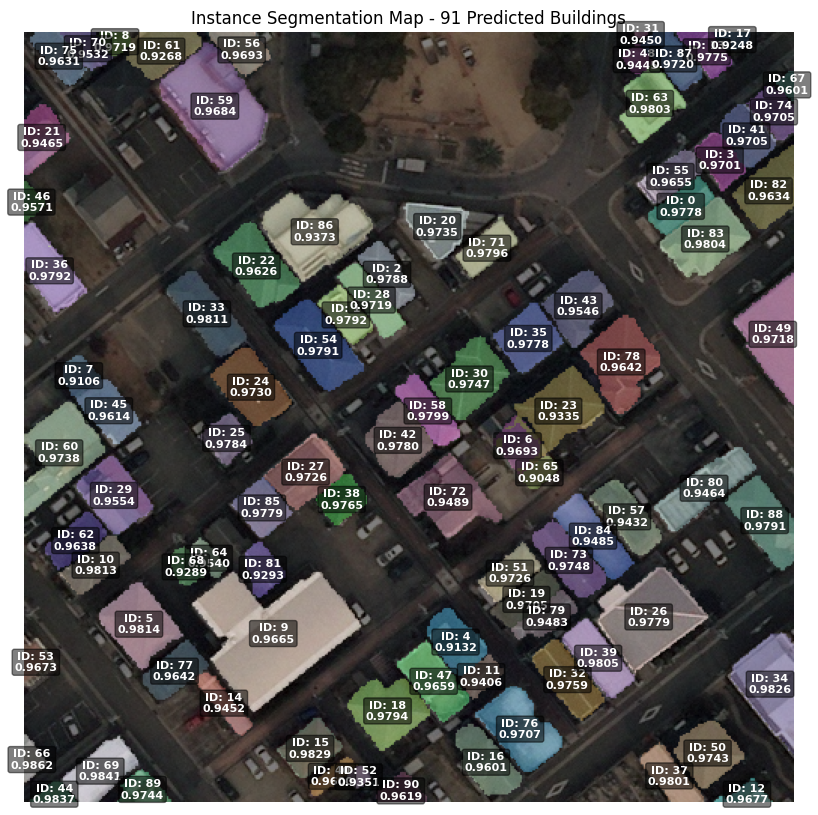

In [10]:
# Quick test
example = dataset["val"][0]
image = example["PIL_image"]

# Run inference
instance_results = run_instance_segmentation(model, processor, image, device, threshold=0.9)

# Visualize prediction
visualize_instance_segmentation_map(instance_results, image, model, alpha=0.5)

Pixel-wise Evaluation:
 iou = 0.8040
 precision = 0.9219
 recall = 0.8628
 f1-score = 0.8914
 accuracy: 0.9149


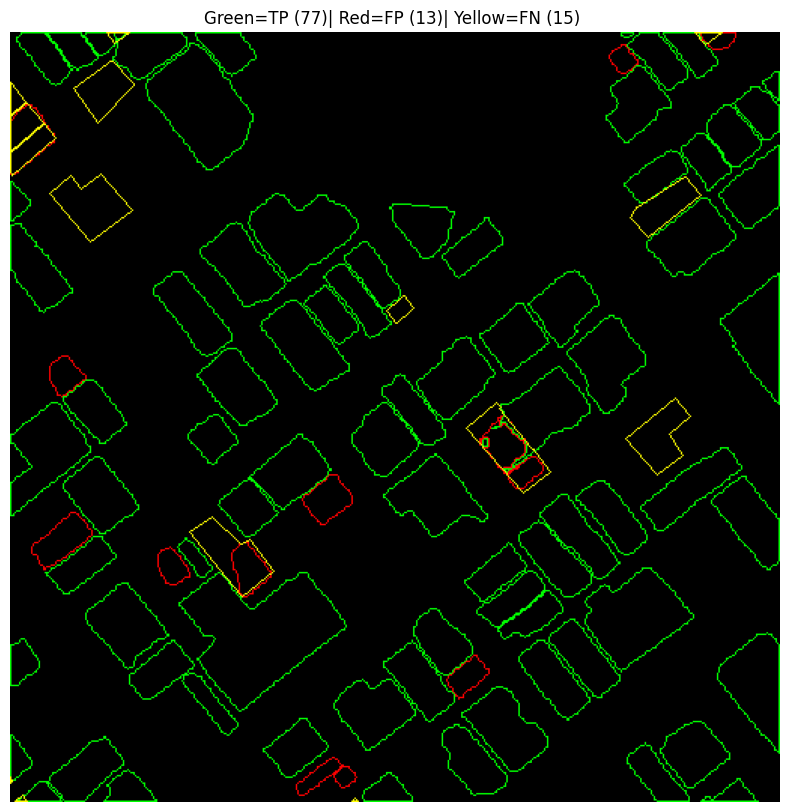

In [11]:
# ----------------------------------------------------------------------------------------
# Compare prediction instance map with true instance map
# ----------------------------------------------------------------------------------------
def normalize_instance_map(instance_map, background_value=255):
    """
    Convert instance IDs to [0..N] where 0 = background.
    
    Args:
        instance_map (ndarray): 2D uint8 or int array.
        background_value (int): Value representing background in the map.
    
    Returns:
        ndarray: Normalized map with instances labeled 1..N and background 0.
    """
    # Create copy to avoid modifying the original
    norm_map = instance_map.copy()

    # Set background to 0
    norm_map[norm_map == background_value] = 0

    # Get sorted unique instance IDs excluding background
    unique_ids = np.unique(norm_map)
    unique_ids = unique_ids[unique_ids != 0]

    # Remap instances to 1..N
    remap_dict = {old_id: new_id for new_id, old_id in enumerate(unique_ids, start=1)}
    for old_id, new_id in remap_dict.items():
        norm_map[instance_map == old_id] = new_id

    return norm_map

# Extract predicted instance map (and normalize to background 0, 1..N instances)
pr_instance_map = normalize_instance_map(instance_results["segmentation"].cpu().numpy().astype(np.uint8))

# Extract ground-truth instance map
gt_instance_map = np.array(example["PIL_annotation"], dtype=np.uint8)[..., 1]   # Green channel

# Binary masks (1 = 'building', 0 = 'background')
pr_binary = (pr_instance_map != 0).astype(np.uint8)
gt_binary = (gt_instance_map != 0).astype(np.uint8)

# Compute pixel-wise accuracy
correct = (pr_binary == gt_binary).sum()
total = pr_binary.size
pixel_accuracy = correct / total

# Compute per pixel metrics
intersection = np.logical_and(pr_binary, gt_binary).sum()
union = np.logical_or(pr_binary, gt_binary).sum()
iou = intersection / union

precision = intersection / pr_binary.sum()
recall = intersection / gt_binary.sum()
f1_score = 2 * precision * recall / (precision + recall)

print(
    f"Pixel-wise Evaluation:\n",
    f"iou = {iou:.4f}\n",
    f"precision = {precision:.4f}\n",
    f"recall = {recall:.4f}\n",
    f"f1-score = {f1_score:.4f}\n",
    f"accuracy: {pixel_accuracy:.4f}")

# TP, FP FN counts approximate as it is using pixel wise map not RLES
visualize_instance_comparison(pr_instance_map, gt_instance_map)



In [13]:
# ----------------------------------------------------------------------------------------
# Pixel-wise and object-wise evaluation helper functions  (target: object-wise F1-score)
#-----------------------------------------------------------------------------------------

from tqdm import tqdm
from pycocotools import mask as mask_utils

def instance_mask_to_coco_rle(instance_mask):
    """
    instance_mask: 2D numpy array with 0=background, 1..N=instance ids
    returns: list of COCO RLE dicts, one per instance
    """
    rles = []
    for instance_id in np.unique(instance_mask):
        if instance_id == 0:
            continue
        mask = (instance_mask == instance_id).astype(np.uint8)
        rle = mask_utils.encode(np.asfortranarray(mask))  # must be Fortran order
        rles.append(rle)
    return rles

def rles_to_iou_matrix(pred_rles, gt_rles):
    """
    Computes the IoU matrix between predicted and ground-truth RLE masks.
    
    Returns:
        iou_matrix: shape (len(pred_rles), len(gt_rles))
    """
    iou_matrix = np.zeros((len(pred_rles), len(gt_rles)), dtype=np.float32)
    
    for i, pred in enumerate(pred_rles):
        for j, gt in enumerate(gt_rles):
            iou = mask_utils.iou([pred], [gt], [0])[0,0]  # use [0] for "ignore" category 0
            iou_matrix[i, j] = iou
    return iou_matrix

def compute_update_tp_tn_fp_fn_pixel(pr_binary, gt_binary, counts):
    # Confusion components
    counts["TP"] += np.logical_and(pr_binary, gt_binary).sum()
    counts["FP"] = np.logical_and(pr_binary, np.logical_not(gt_binary)).sum()
    counts["FN"] = np.logical_and(np.logical_not(pr_binary), gt_binary).sum()
    counts["TN"] = np.logical_and(np.logical_not(pr_binary), np.logical_not(gt_binary)).sum()
    return counts

def compute_metrics_pixel(counts):
    # Extract counts
    TP = counts["TP"]
    FP = counts["FP"]
    FN = counts["FN"]
    TN = counts["TN"]

    # Metrics
    metrics = {}
    metrics["accuracy"] = (TP + TN) / (TP + TN + FP + FN)
    metrics["precision"] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    metrics["recall"] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    metrics["f1-score"] = 2 * metrics["precision"] * metrics["recall"] / (metrics["precision"] + metrics["recall"]) if (metrics["precision"] + metrics["recall"]) > 0 else 0.0
    metrics["iou"] = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0.0

    return metrics

def compute_update_tp_fp_fn_rle(pred_rles, gt_rles, counts, iou_threshold=0.5):
    """
    Computes TP, FP, FN for a single sample using predicted and GT RLEs.
    """

    # Update GT and PR
    counts["GT"] += len(gt_rles)
    counts["PR"] += len(pred_rles)

    if len(pred_rles) == 0:
        counts["FN"] += len(gt_rles)
        return counts
    if len(gt_rles) == 0:
        counts["FP"] += len(pred_rles)
        return counts

    # Compute IoU matrix in one call
    iou_matrix = mask_utils.iou(pred_rles, gt_rles, np.zeros(len(gt_rles), dtype=np.int32))  # shape: (len(pred_rles), len(gt_rles))
    
    matched_gt = set()
    TP = 0
    FP = 0

    # Greedy matching
    for i in range(iou_matrix.shape[0]):
        j = np.argmax(iou_matrix[i])
        iou = iou_matrix[i, j]
        if iou >= iou_threshold and j not in matched_gt:
            TP += 1
            matched_gt.add(j)
        else:
            FP += 1

    FN = len(gt_rles) - len(matched_gt)
    counts["TP"] += TP
    counts["FP"] += FP
    counts["FN"] += FN
    return counts

def compute_f1_from_counts(counts):
    total_TP, total_FP, total_FN = counts["TP"], counts["FP"], counts["FN"]
    
    metrics = {}
    metrics["precision"] = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0.0
    metrics["recall"] = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0.0
    metrics["f1-score"] = (2 * metrics["precision"] * metrics["recall"] / (metrics["precision"] + metrics["recall"])) if (metrics["precision"] + metrics["recall"]) > 0 else 0.0
    return metrics

In [19]:
# ----------------------------------------------------------------------------------------
# Grid-search on model output score threshold (target: maximize object-wise F1-score)
#-----------------------------------------------------------------------------------------

def grid_search_threshold(dataset_split, model, processor, device, thresholds=[0.5]):
    
    print("Grid Search:")
    print("-----------")
    print("Threshold values: ", thresholds)
    
    history = {"thresholds": [], "results": []}
    best_threshold = thresholds[0]
    best_results = {
        "pixel_wise": {},
        "object_wise": {}
    }
    for threshold in thresholds:
        
        # Evaluate
        model.eval()

        pixel_wise = {
            "counts": {
                "TP": 0,
                "TN": 0,
                "FP": 0,
                "FN": 0,
            },
            "metrics": {
                "precision": 0,
                "recall": 0,
                "f1-score": 0,
                "accuracy": 0,
                "iou": 0
            }
        }
        object_wise = {
            "counts": {
                "GT": 0,
                "PR": 0,
                "TP": 0,
                "FP": 0,
                "FN": 0,
            },
            "metrics": {
                "precision": 0,
                "recall": 0,
                "f1-score": 0
            }
        }

        print("Threshold: ", threshold)
        for idx in tqdm(range(len(dataset_split)), total=len(dataset_split)):
            example = dataset_split[idx]
            # Extract image
            image = example["PIL_image"]

            # Extract ground-truth instance segmentation map
            gt_instance_map = np.array(example["PIL_annotation"], dtype=np.uint8)[..., 1]   # Green channel

            # Run inference
            instance_results = run_instance_segmentation(model, processor, image, device, threshold=threshold)
            
            # Extract prediction instance segmentation map
            pr_instance_map = instance_results["segmentation"].cpu().numpy().astype(np.uint8)

            # Convert instance segmentation maps to RLEs
            gt_rles = instance_mask_to_coco_rle(gt_instance_map)
            pr_rles = instance_mask_to_coco_rle(normalize_instance_map(pr_instance_map))    # Normalize predictions to background 0 and instances 1...

            # Update counts
            pixel_wise["counts"] = compute_update_tp_tn_fp_fn_pixel((pr_instance_map != 0), (gt_instance_map != 0), pixel_wise["counts"])
            object_wise["counts"] = compute_update_tp_fp_fn_rle(pr_rles, gt_rles, object_wise["counts"])

        # Compute metrics
        pixel_wise["metrics"] = compute_metrics_pixel(pixel_wise["counts"])

        object_wise["metrics"] = compute_f1_from_counts(object_wise["counts"])

        # Update best results
        if "metrics" not in best_results["object_wise"].keys() or object_wise["metrics"]["f1-score"] >= best_results["object_wise"]["metrics"]["f1-score"]:
            # Update
            best_threshold = threshold
            best_results["object_wise"] = {"counts": object_wise["counts"], "metrics": object_wise["metrics"]}
            best_results["pixel_wise"] = {"counts": pixel_wise["counts"], "metrics": pixel_wise["metrics"]}

        history["thresholds"].append(threshold)
        history["results"].append({"pixel_wise": {"counts": pixel_wise["counts"], "metrics": pixel_wise["metrics"]}, "object_wise": {"counts": object_wise["counts"], "metrics": object_wise["metrics"]}})

        # Print (could log but it's easy to see with a print)
        print("Pixel-wise Evaluation:")
        for k, v in pixel_wise["counts"].items():
            print(f"{k}: {v:.4f}", end=" ")
        for k, v in pixel_wise["metrics"].items():
            print(f"{k}: {v:.4f}", end=" ")
        print("")
        
        print("Object-wise Evaluation:")
        for k, v in object_wise["counts"].items():
            print(f"{k}: {v:.4f}", end=" ")
        for k, v in object_wise["metrics"].items():
            print(f"{k}: {v:.4f}", end=" ")
        print("\n")

    return best_threshold, best_results, history

# Do a grid-search to select best threshold (based on object-wise F1-score)
best_threshold, best_results, history = grid_search_threshold(dataset["val"], model, processor, device, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Print metrics
print("Optimal Threshold: ", best_threshold)
print("Results: ")
print("Pixel-wise Evaluation:")
for k, v in best_results["pixel_wise"]["counts"].items():
    print(f"{k}: {v:.4f}", end=" ")
for k, v in best_results["pixel_wise"]["metrics"].items():
    print(f"{k}: {v:.4f}", end=" ")
print("")

print("Object-wise Evaluation:")
for k, v in best_results["object_wise"]["counts"].items():
    print(f"{k}: {v:.4f}", end=" ")
for k, v in best_results["object_wise"]["metrics"].items():
    print(f"{k}: {v:.4f}", end=" ")
print("\n")

Grid Search:
-----------
Threshold values:  [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Threshold:  0.3


100%|██████████| 933/933 [11:09<00:00,  1.39it/s]


Pixel-wise Evaluation:
TP: 65944893.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9967 precision: 0.9967 recall: 1.0000 f1-score: 0.9983 iou: 0.9967 
Object-wise Evaluation:
GT: 37674.0000 PR: 60995.0000 TP: 29705.0000 FP: 31290.0000 FN: 7969.0000 precision: 0.4870 recall: 0.7885 f1-score: 0.6021 

Threshold:  0.4


100%|██████████| 933/933 [11:35<00:00,  1.34it/s]


Pixel-wise Evaluation:
TP: 65665766.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9967 precision: 0.9967 recall: 1.0000 f1-score: 0.9983 iou: 0.9967 
Object-wise Evaluation:
GT: 37674.0000 PR: 57524.0000 TP: 29776.0000 FP: 27748.0000 FN: 7898.0000 precision: 0.5176 recall: 0.7904 f1-score: 0.6256 

Threshold:  0.5


100%|██████████| 933/933 [11:26<00:00,  1.36it/s]


Pixel-wise Evaluation:
TP: 65386198.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9967 precision: 0.9967 recall: 1.0000 f1-score: 0.9983 iou: 0.9967 
Object-wise Evaluation:
GT: 37674.0000 PR: 54349.0000 TP: 29751.0000 FP: 24598.0000 FN: 7923.0000 precision: 0.5474 recall: 0.7897 f1-score: 0.6466 

Threshold:  0.6


100%|██████████| 933/933 [11:13<00:00,  1.39it/s]


Pixel-wise Evaluation:
TP: 65064976.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9967 precision: 0.9967 recall: 1.0000 f1-score: 0.9983 iou: 0.9967 
Object-wise Evaluation:
GT: 37674.0000 PR: 51316.0000 TP: 29759.0000 FP: 21557.0000 FN: 7915.0000 precision: 0.5799 recall: 0.7899 f1-score: 0.6688 

Threshold:  0.7


100%|██████████| 933/933 [11:10<00:00,  1.39it/s]


Pixel-wise Evaluation:
TP: 64741785.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9966 precision: 0.9966 recall: 1.0000 f1-score: 0.9983 iou: 0.9966 
Object-wise Evaluation:
GT: 37674.0000 PR: 47885.0000 TP: 29639.0000 FP: 18246.0000 FN: 8035.0000 precision: 0.6190 recall: 0.7867 f1-score: 0.6928 

Threshold:  0.8


100%|██████████| 933/933 [11:06<00:00,  1.40it/s]


Pixel-wise Evaluation:
TP: 64158586.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9966 precision: 0.9966 recall: 1.0000 f1-score: 0.9983 iou: 0.9966 
Object-wise Evaluation:
GT: 37674.0000 PR: 43707.0000 TP: 29394.0000 FP: 14313.0000 FN: 8280.0000 precision: 0.6725 recall: 0.7802 f1-score: 0.7224 

Threshold:  0.9


100%|██████████| 933/933 [11:02<00:00,  1.41it/s]

Pixel-wise Evaluation:
TP: 63766004.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9966 precision: 0.9966 recall: 1.0000 f1-score: 0.9983 iou: 0.9966 
Object-wise Evaluation:
GT: 37674.0000 PR: 36316.0000 TP: 27990.0000 FP: 8326.0000 FN: 9684.0000 precision: 0.7707 recall: 0.7430 f1-score: 0.7566 

Optimal Threshold:  0.9
Results: 
Pixel-wise Evaluation:
TP: 63766004.0000 TN: 15.0000 FP: 217713.0000 FN: 669.0000 accuracy: 0.9966 precision: 0.9966 recall: 1.0000 f1-score: 0.9983 iou: 0.9966 
Object-wise Evaluation:
GT: 37674.0000 PR: 36316.0000 TP: 27990.0000 FP: 8326.0000 FN: 9684.0000 precision: 0.7707 recall: 0.7430 f1-score: 0.7566 



In [ ]:
# Plot the metrics per threshold
# TODO:

import json

# Helper to convert NumPy types automatically
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(i) for i in obj]
    else:
        return obj

# Convert and save
history_clean = convert_numpy(history)

with open("evaluation/mask2former-swin-large-coco-instance-finetuned-buildings/history.json", "w") as f:
    json.dump(history_clean, f, indent=4)

Highest object-wise F1-score: 0.7566 at threshold 0.9


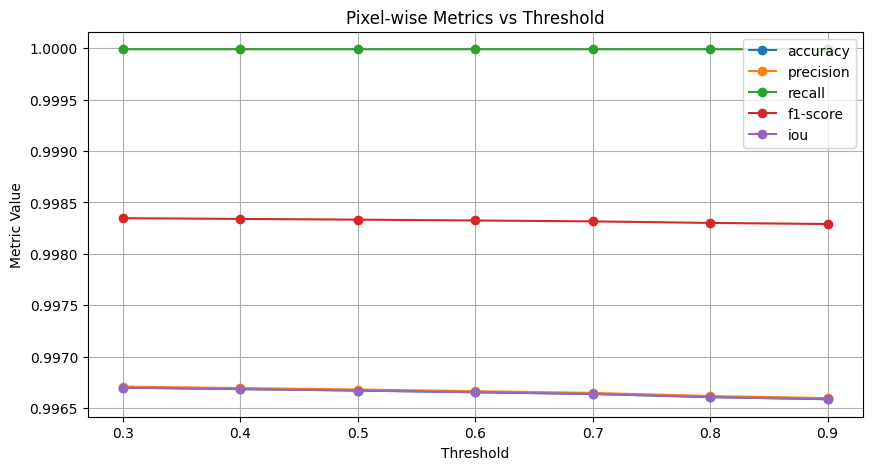

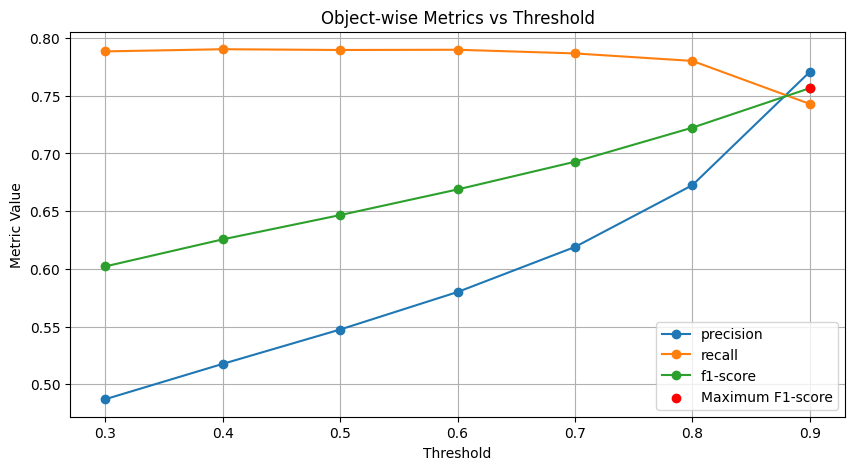

In [14]:
import json
import matplotlib.pyplot as plt

with open("evaluation/mask2former-swin-large-coco-instance-finetuned-buildings/history.json", "r") as f:
    data = json.load(f)

thresholds = data['thresholds']

# Extract metrics
pixel_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1-score': [], 'iou': []}
object_metrics = {'precision': [], 'recall': [], 'f1-score': []}

for result in data['results']:
    for m in pixel_metrics.keys():
        pixel_metrics[m].append(result['pixel_wise']['metrics'][m])
    for m in object_metrics.keys():
        object_metrics[m].append(result['object_wise']['metrics'][m])

# Extract object-wise F1-scores
object_f1 = [res['object_wise']['metrics']['f1-score'] for res in data['results']]

# Identify highest object-wise F1-score
max_obj_f1 = max(object_f1)
max_index = object_f1.index(max_obj_f1)
best_threshold = thresholds[max_index]
print(f"Highest object-wise F1-score: {max_obj_f1:.4f} at threshold {best_threshold}")

# Plot Pixel-wise metrics
plt.figure(figsize=(10, 5))
for metric, values in pixel_metrics.items():
    plt.plot(thresholds, values, marker='o', label=metric)
plt.title('Pixel-wise Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()

# Save plot
plt.savefig('evaluation/mask2former-swin-large-coco-instance-finetuned-buildings/pixel_wise_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Object-wise metrics
plt.figure(figsize=(10, 5))
for metric, values in object_metrics.items():
    plt.plot(thresholds, values, marker='o', label=metric)
plt.scatter(best_threshold, max_obj_f1, color='red', zorder=5, label='Maximum F1-score')
plt.title('Object-wise Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
# Save plot
plt.savefig('evaluation/mask2former-swin-large-coco-instance-finetuned-buildings/object_wise_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# ----------------------------------------------------------------------------------------
# Inference on test images and submission
#-----------------------------------------------------------------------------------------

import pandas as pd
import pycocotools.mask as mask_utils

from tqdm import tqdm

def rles_to_coordinates(rles):
    """
    Convert each single COCO RLE to a list of polygons.
    Returns a flatten list of polygons in coordinates (each polygon is a list of (x,y) tuples) as a string.
    """
    # For each RLE compute the polygon
    all_polygons = []
    for rle in rles:
        mask = mask_utils.decode(rle).astype(np.uint8)  # H x W, 0/1
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for cnt in contours:
            if len(cnt) >= 3:
                polygons.append([(int(x), int(y)) for x, y in cnt.squeeze()])
        all_polygons.extend(polygons)
    
    # Convert list of polygons to string format for CSV
    # Each building coordinates is a list of (x, y) tuples
    if len(all_polygons) == 0:
        coord_str = "[]"
    else:
        # Flatten list of coordinates: here we store each coordinates as a separate list
        coord_str = str(all_polygons)

    return coord_str

# --- Paths ---
output_csv = "submission-5676-09.csv"

model.eval()

# Best validation threshold
threshold = 0.9
submission_rows = []
lenght = len(dataset["test"])
for idx in tqdm(range(lenght), total=lenght):
    
    example = dataset["test"][idx]

    # Extract img_id and image
    img_id = example["image_info"]["id"]
    image = example["PIL_image"]

    # Run inference
    instance_results = run_instance_segmentation(model, processor, image, device, threshold=threshold)
    
    # Extract prediction instance segmentation map
    pr_instance_map = instance_results["segmentation"].cpu().numpy().astype(np.uint8)

    # Convert instance segmentation maps to RLEs
    pr_rles = instance_mask_to_coco_rle(normalize_instance_map(pr_instance_map))

    # Convert RLEs to polygon coordinates
    coords_str = rles_to_coordinates(pr_rles)

    # Update submission csv
    submission_rows.append({
            "ImageID": img_id,
            "Coordinates": coords_str
        })
    
# Save CSV
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv(output_csv, index=False)
print(f"Saved {output_csv} with", len(submission_df), "rows")

100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


Saved submission-5676-09.csv with 1000 rows
